In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
import json
from zipfile import ZipFile

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [ ]:
kaggle_credentails = json.load(open("kaggle.json"))

In [ ]:
# setup Kaggle API key as environment variables

os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:00<00:00, 1.54GB/s]
100% 149M/149M [00:00<00:00, 1.53GB/s]


In [ ]:
# Unzip the downloaded dataset
with ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
train_dir = 'Training'
test_dir = 'Testing'

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=True
)

Found 5712 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

Found 1311 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(f"Class Names: {class_names}")


Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Custom CNN


from tensorflow.keras import Input, layers, models

def create_modern_model(input_shape, num_classes):
    inputs= Input(shape=input_shape)

    #Data Augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)

    x = layers.Rescaling(1./255)(x)

    #1
    x = layers.Conv2D(32, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)  #64*64

    #2
    x = layers.Conv2D(64, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x) #32*32

    #3
    x = layers.Conv2D(128, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x) #16*16

    #4
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs =layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


model = create_modern_model(input_shape=(128,128,3) , num_classes=4)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 390,884 (1.49 MB)

 Trainable params: 389,924 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks=[
    EarlyStopping(
        patience=5,
        restore_best_weights=True,
        verbose=1
        ),

    ModelCheckpoint(
        'brain_tumor_model.keras',
        save_best_only=True,
        verbose=1
        ),

    ReduceLROnPlateau(
        factor=0.5,
        patience=2,
        verbose=1
        )
]

In [ ]:
history= model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 20,
    callbacks = callbacks
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6422 - loss: 0.8831
Epoch 1: val_loss improved from inf to 2.62041, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6425 - loss: 0.8825 - val_accuracy: 0.2662 - val_loss: 2.6204 - learning_rate: 0.0010
Epoch 2/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7574 - loss: 0.6346
Epoch 2: val_loss improved from 2.62041 to 1.25953, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7573 - loss: 0.6347 - val_accuracy: 0.5072 - val_loss: 1.2595 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7753 - loss: 0.5785
Epoch 3: val_loss improved from 1.25953 to 0.80242, saving model to brain_tumor_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7753 - loss: 0.5785 - val_accuracy: 0.6354 - val_loss: 0.8024 - learning_rate: 0.0010
Epoch 4/20
178/179 ━━━━━━━━━━━━━━━━━━━━

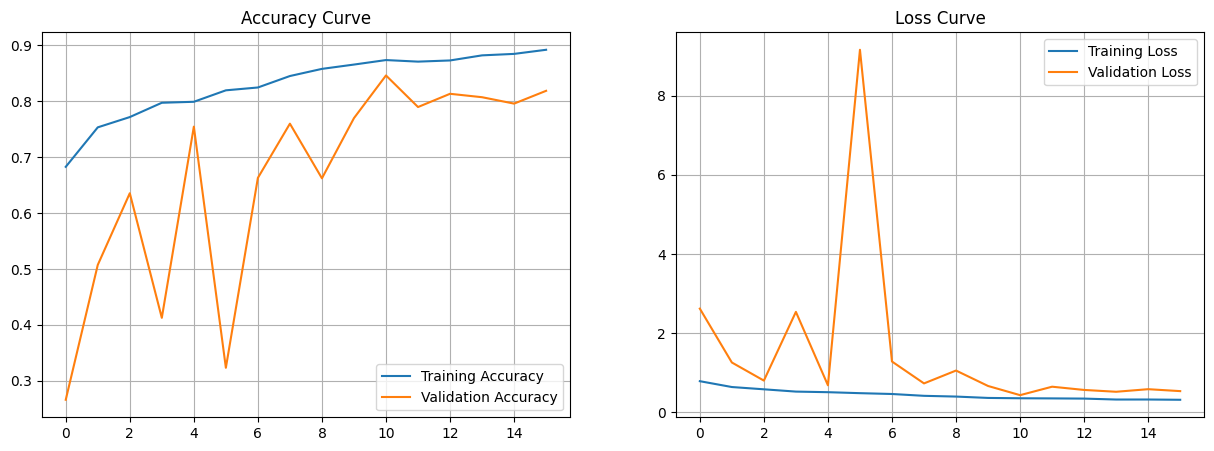

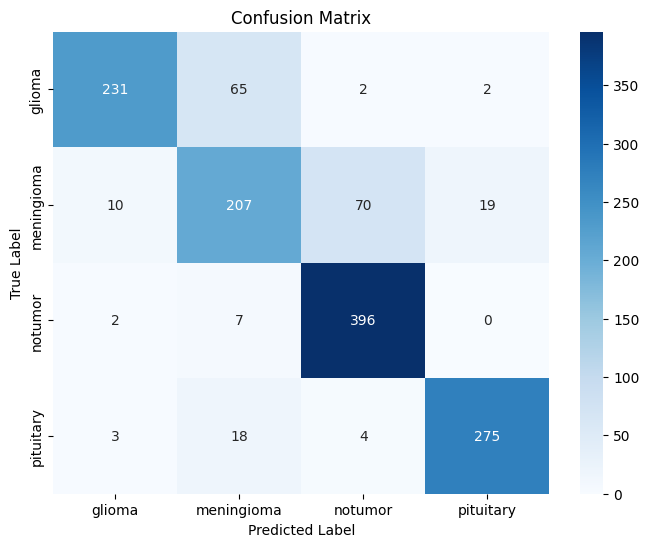

              precision    recall  f1-score   support

      glioma       0.94      0.77      0.85       300
  meningioma       0.70      0.68      0.69       306
     notumor       0.84      0.98      0.90       405
   pituitary       0.93      0.92      0.92       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.84      1311



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ============================================================
# LEARNING CURVES
# ============================================================

train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(len(train_acc))

plt.figure(figsize=(15, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve')
plt.grid(True)

plt.show()

# ============================================================
# CONFUSION MATRIX
# ============================================================

y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ============================================================
# CLASSIFICATION REPORT
# ============================================================

print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# VGG16 + Transfer Learning + FineTune

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input, optimizers

def create_finetune_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.Rescaling(1./255)(x)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = True
    for layer in base_model.layers:
        if 'block5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


finetune_model = create_finetune_model(input_shape=(128, 128, 3), num_classes=4)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
finetune_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), # 0.00001
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [ ]:
finetune_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 7,081,476 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_finetuned=[
    EarlyStopping(
        patience=5,
        restore_best_weights=True,
        verbose=1
        ),

    ModelCheckpoint(
        'brain_tumor_model_vgg16.keras',
        save_best_only=True,
        verbose=1
        ),

    ReduceLROnPlateau(
        factor=0.5,
        patience=2,
        verbose=1
        )
]

In [ ]:
history_finetune = finetune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_finetuned
)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4358 - loss: 1.3120
Epoch 1: val_loss improved from inf to 0.61262, saving model to brain_tumor_model_vgg16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.4366 - loss: 1.3104 - val_accuracy: 0.7796 - val_loss: 0.6126 - learning_rate: 1.0000e-05
Epoch 2/30
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8015 - loss: 0.5399
Epoch 2: val_loss improved from 0.61262 to 0.46362, saving model to brain_tumor_model_vgg16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8017 - loss: 0.5394 - val_accuracy: 0.8299 - val_loss: 0.4636 - learning_rate: 1.0000e-05
Epoch 3/30
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8586 - loss: 0.3885
Epoch 3: val_loss improved from 0.46362 to 0.41356, saving model to brain_tumor_model_vgg16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.8587 - loss: 0.3883 - val_accuracy: 0.8574 - val_loss: 0.4136 - learning_rate: 1.0000e-05
Epoch 4/

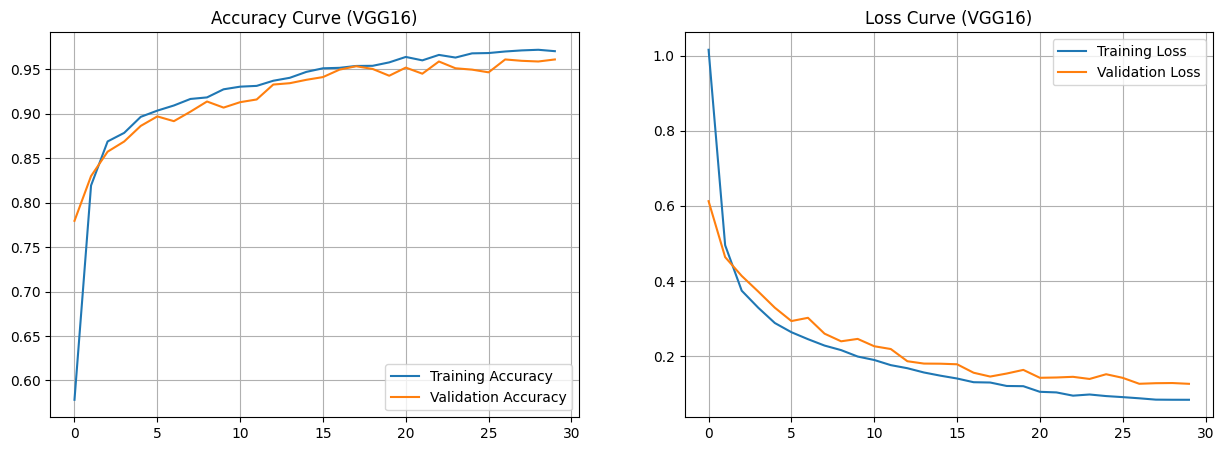

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

train_acc = history_finetune.history['accuracy']
val_acc   = history_finetune.history['val_accuracy']
train_loss = history_finetune.history['loss']
val_loss   = history_finetune.history['val_loss']

epochs_range = range(len(train_acc))

plt.figure(figsize=(15, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve (VGG16)')
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve (VGG16)')
plt.grid(True)

plt.show()


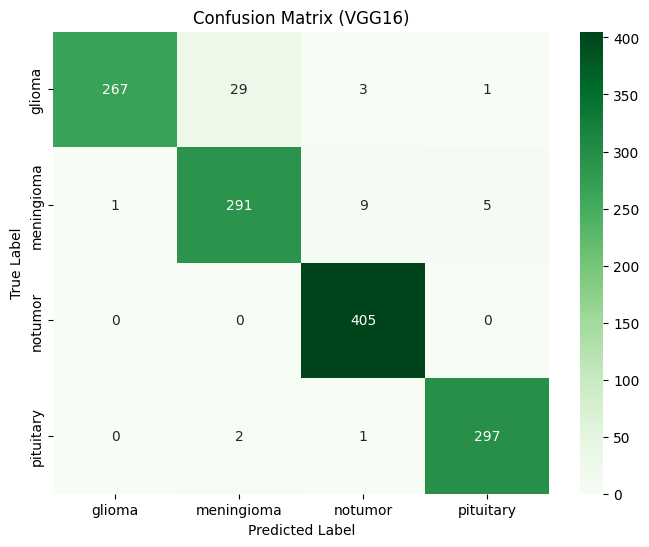

In [ ]:
# CONFUSION MATRIX (VGG16)

y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = finetune_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (VGG16)')
plt.show()


In [ ]:
print("Classification Report (VGG16 Fine-Tuned Model)")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report (VGG16 Fine-Tuned Model)
              precision    recall  f1-score   support

      glioma       1.00      0.89      0.94       300
  meningioma       0.90      0.95      0.93       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



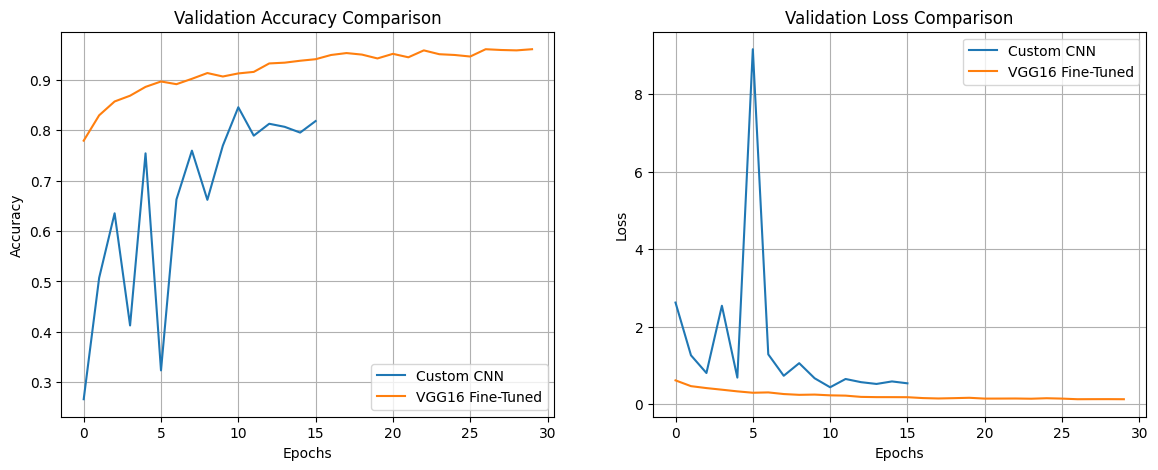

In [ ]:
# CNN vs VGG16 – Accuracy & Loss Comparison Plots


# Accuracy Comparison
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='Custom CNN')
plt.plot(history_finetune.history['val_accuracy'], label='VGG16 Fine-Tuned')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Loss Comparison
plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Custom CNN')
plt.plot(history_finetune.history['val_loss'], label='VGG16 Fine-Tuned')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/Brain_Tumor_detection"

In [ ]:
import os
os.makedirs(save_path, exist_ok=True)

In [ ]:
model.save(save_path + "/custom_cnn_model.keras")

In [ ]:
finetune_model.save(save_path + "/vgg16_finetuned_model.keras")

In [ ]:
import json

with open(save_path + "/class_names.json", "w") as f:
    json.dump(class_names, f)

In [ ]:
import cv2
import numpy as np

def predict_brain_tumor(image_path, model, class_names, img_size=128):
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, (img_size, img_size))


    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    # Prediction
    preds = model.predict(img)
    predicted_class = np.argmax(preds)
    confidence = np.max(preds)

    return class_names[predicted_class], confidence

In [ ]:
image_path = "/content/Testing/notumor/Te-noTr_0005.jpg"

label, confidence = predict_brain_tumor(
    image_path,
    model,
    class_names
)

print(f"Custom CNN Prediction: {label} ({confidence*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Custom CNN Prediction: notumor (99.92%)


In [ ]:
image_path = "/content/Testing/notumor/Te-noTr_0005.jpg"

label, confidence = predict_brain_tumor(
    image_path,
    finetune_model,
    class_names
)

print(f"VGG16 Prediction: {label} ({confidence*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
VGG16 Prediction: notumor (99.92%)


In [ ]:
image_path = "/content/Testing/pituitary/Te-pi_0015.jpg"

label, confidence = predict_brain_tumor(
    image_path,
    finetune_model,
    class_names
)

print(f"VGG16 Prediction: {label} ({confidence*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
VGG16 Prediction: pituitary (99.95%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

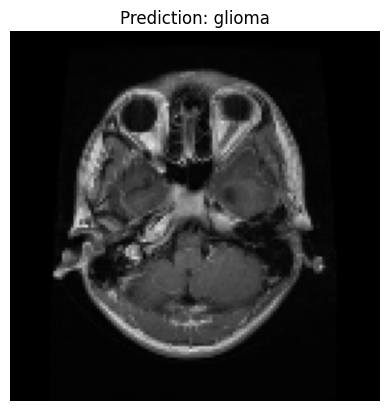

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/Testing/glioma/Te-glTr_0003.jpg"   # path to your MRI image

# Load image
img = tf.keras.utils.load_img(
    img_path,
    target_size=(128, 128)
)

# Convert to array
img_array = tf.keras.utils.img_to_array(img)

# Add batch dimension
img_array = tf.expand_dims(img_array, axis=0)

# Load model
model = tf.keras.models.load_model("brain_tumor_model.keras")

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Display
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

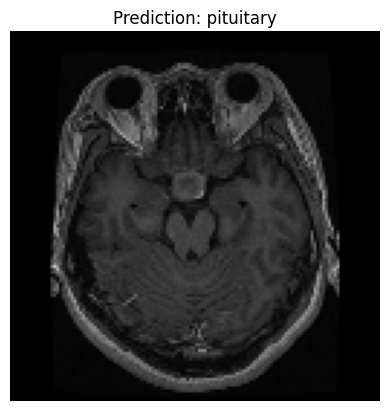

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/Testing/pituitary/Te-piTr_0009.jpg"   # path to your MRI image

# Load image
img = tf.keras.utils.load_img(
    img_path,
    target_size=(128, 128)
)

# Convert to array
img_array = tf.keras.utils.img_to_array(img)

# Add batch dimension
img_array = tf.expand_dims(img_array, axis=0)

# Load model
model = tf.keras.models.load_model("brain_tumor_model_vgg16.keras")

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Display
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis("off")